<a href="https://colab.research.google.com/github/knk190001/SlantClassification/blob/master/SlantDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/knk190001/SlantClassification.git

fatal: destination path 'SlantClassification' already exists and is not an empty directory.


In [0]:
import pandas as pd
import json

In [3]:
data = pd.read_csv('./SlantClassification/tweets.csv')
reps = pd.read_json('./SlantClassification/representatives.json')
sens = pd.read_json('./SlantClassification/senators.json')

def findParty(user):
  temp = reps[reps['Twitter_username']==user]
  if temp.empty :
    temp = sens[sens['Twitter_username']==user]
  
  if temp.empty:
    return
  if temp.iloc[0,2] == 'Democratic Party' :
    return int(1)
  elif temp.iloc[0,2] == 'Republican Party' :
    return int(0)

data['user'] = data['user'].apply(findParty)

data.sample(5)

,user,text
67730,1.0,I have a lot of respect for General Mattis and...
64203,1.0,There was an incredible feeling of energy and ...
98733,1.0,Wisconsinites you can register and vote on El...
10906,1.0,Given the positions he has taken in litigation...
31847,1.0,Al is proud to be @HRC endorsed: http://t.co/V...


In [0]:
import re

def remove(pattern,text):
  if isinstance(text,str):
    return re.sub(pattern,'',text)
  return float('nan')

def removeLinks(text):
  return remove(r'https?:\/\/.*[\r\n]*',text)
def removeHandles(text):
  return remove(r'@\w{1,15}',text)
def removeHashtags(text):
  return remove(r'#\w*[A-Za-z_]+\w*',text)

data['text'] = data['text'].apply(removeLinks).apply(removeHandles).apply(removeHashtags).dropna()

In [5]:
data.columns = ['party','text']
data = data.dropna()
data.head(20)

,party,text
1,0.0,Nancy Pelosi and Adam Schiffs impeachment was ...
2,0.0,One of the reasons for the Democrats' impeachm...
3,0.0,It was great to see so many friends tonight at...
4,0.0,READ MY FULL STATEMENT HERE:
5,0.0,. is a foot soldier for Chuck Schumer and the ...
6,0.0,. is deeply complicit in this grave wrong. In ...
7,0.0,They fear our strong President who is boldly ...
8,0.0,House Democrats have committed a very grave wr...
9,0.0,As I have stated from the beginning on multipl...
10,0.0,The Democrats partisan impeachment charade has...


In [6]:
!pip install transformers

In [0]:
import os
import torch

In [0]:
data = data.sample(frac=1).reset_index(drop=True).dropna()
phaseOne = data.head(int(len(data.index) * .75)).reset_index(drop=True)
phaseTwo = data.tail(int(len(data.index)*.25)).reset_index(drop=True)

In [9]:
phaseOne

,party,text
0,0.0,Island nations and territories already bear th...
1,0.0,"Im encouraged that this bill, which passed wit..."
2,1.0,50 yrs ago today people were killed in a deadl...
3,0.0,Great photos from my tour through this week ...
4,0.0,Very sad to hear about Charles .He is one of t...
...,...,...
101324,1.0,Thank you ! Proud to work with you to protect ...
101325,1.0,"No matter where you come from, no matter who y..."
101326,0.0,Healthy oceans are vital to a healthy economy ...
101327,1.0,"Unlike the White House proposals, my legislati..."


In [10]:
phaseTwo

,party,text
0,1.0,"""I am alive today not because of insurance com..."
1,1.0,"As a former social worker, I've seen first-han..."
2,1.0,"Today, Vietnam War Veterans Day, we pause to h..."
3,1.0,"""It's humiliating. Honestly, Bern, it's humili..."
4,1.0,Words fail.
...,...,...
33771,0.0,The Senate just voted to begin debate on the f...
33772,1.0,Reminder:
33773,0.0,NEW AD: Washington is rigged for the well-conn...
33774,0.0,"Happy Birthday, 45! We hope youre able to fin..."


In [11]:
if torch.cuda.is_available():
  print("cuda")
  device = torch.device("cuda")
else:
  print('cpu')
  device = torch.device("cpu")

cuda


In [0]:
tweets = phaseOne.text.values
labels = phaseOne.party.values

In [0]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [14]:
print('Original: ',tweets[0])
print('Tokenized: ',tokenizer.tokenize(tweets[0]))
print('Token IDs: ',tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[0])))

Original:  Island nations and territories already bear the brunt of climate change. I'm thrilled to be in the U.S. Virgin Isla 
Tokenized:  ['island', 'nations', 'and', 'territories', 'already', 'bear', 'the', 'br', '##unt', 'of', 'climate', 'change', '.', 'i', "'", 'm', 'thrilled', 'to', 'be', 'in', 'the', 'u', '.', 's', '.', 'virgin', 'isla']
Token IDs:  [2479, 3741, 1998, 6500, 2525, 4562, 1996, 7987, 16671, 1997, 4785, 2689, 1012, 1045, 1005, 1049, 16082, 2000, 2022, 1999, 1996, 1057, 1012, 1055, 1012, 6261, 25340]


In [15]:
input_ids = []

for tweet in tweets:
  encoded_tweet = tokenizer.encode(tweet,add_special_tokens=True)
  input_ids.append(encoded_tweet)

print('Max length: ', max([len(tweet) for tweet in input_ids]))

Max length:  54


In [0]:
from keras_preprocessing.sequence import pad_sequences

MAX_LEN = 64

input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype='long',value=0, truncating='post',padding='post')


In [0]:
attention_mask = []

for tweet in input_ids:
  att_mask = [int(token_id>0) for token_id in tweet]
  attention_mask.append(att_mask)

In [0]:
 from sklearn.model_selection import train_test_split

 train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,labels,random_state=2018,test_size=0.1)

 train_masks, validation_masks, _, _, = train_test_split(attention_mask,labels,random_state=2018,test_size=0.1)

In [0]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_inputs,train_masks,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

validation_data = TensorDataset(validation_inputs,validation_masks,validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,sampler=validation_sampler,batch_size = batch_size)

In [21]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2,output_attentions=False,output_hidden_states=False)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
optimizer = AdamW(model.parameters(),lr=2e-5,eps=1e-8)

In [0]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader)*epochs

scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = 0, num_training_steps = total_steps)

In [0]:
import numpy as np

def flat_accuracy(preds,labels):
  pred_flat = np.argmax(preds,axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat==labels_flat)/len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [27]:
import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0,epochs):
  print('')
  print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
  print('Training...')

  t0 = time.time()

  total_loss = 0

  model.train()

  for step,batch in enumerate(train_dataloader):
    if step % 400 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].long().to(device)

    model.zero_grad()

    outputs = model(b_input_ids,token_type_ids = None, attention_mask = b_input_mask,labels=b_labels)

    loss = outputs[0]

    total_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

    optimizer.step()

    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)

  loss_values.append(avg_train_loss)

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

  print("")
  print("Running Validation...")

  t0 = time.time()

  model.eval()

  eval_loss,eval_accuracy=0,0
  nb_eval_steps,nb_eval_examples = 0,0

  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids,token_type_ids = None,attention_mask = b_input_mask)

    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits,label_ids)

    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1
  print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")



======== Epoch 1 / 4 ========
Training...
  Batch   400  of  2,850.    Elapsed: 0:02:41.
  Batch   800  of  2,850.    Elapsed: 0:05:26.
  Batch 1,200  of  2,850.    Elapsed: 0:08:10.
  Batch 1,600  of  2,850.    Elapsed: 0:10:54.
  Batch 2,000  of  2,850.    Elapsed: 0:13:38.
  Batch 2,400  of  2,850.    Elapsed: 0:16:22.
  Batch 2,800  of  2,850.    Elapsed: 0:19:06.

  Average training loss: 0.40
  Training epcoh took: 0:19:27

Running Validation...
  Accuracy: 0.82
  Validation took: 0:00:43

======== Epoch 2 / 4 ========
Training...
  Batch   400  of  2,850.    Elapsed: 0:02:44.
  Batch   800  of  2,850.    Elapsed: 0:05:28.
  Batch 1,200  of  2,850.    Elapsed: 0:08:12.
  Batch 1,600  of  2,850.    Elapsed: 0:10:56.
  Batch 2,000  of  2,850.    Elapsed: 0:13:41.
  Batch 2,400  of  2,850.    Elapsed: 0:16:25.
  Batch 2,800  of  2,850.    Elapsed: 0:19:10.

  Average training loss: 0.29
  Training epcoh took: 0:19:30

Running Validation...
  Accuracy: 0.84
  Validation took: 0:00:4

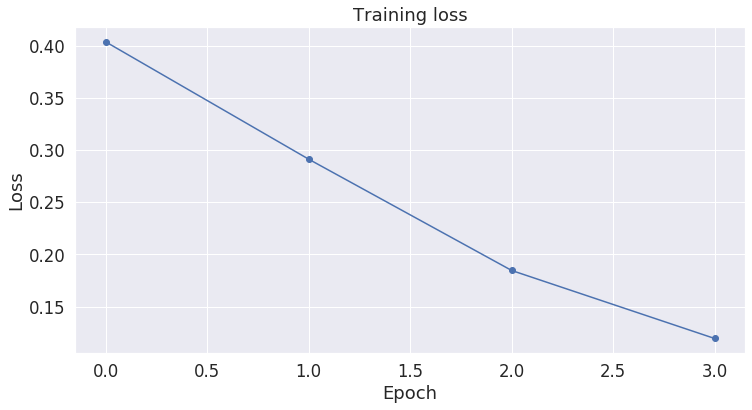

In [28]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12,6)

plt.plot(loss_values,'b-o')

plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [29]:
phaseTwo

,party,text
0,1.0,"""I am alive today not because of insurance com..."
1,1.0,"As a former social worker, I've seen first-han..."
2,1.0,"Today, Vietnam War Veterans Day, we pause to h..."
3,1.0,"""It's humiliating. Honestly, Bern, it's humili..."
4,1.0,Words fail.
...,...,...
33771,0.0,The Senate just voted to begin debate on the f...
33772,1.0,Reminder:
33773,0.0,NEW AD: Washington is rigged for the well-conn...
33774,0.0,"Happy Birthday, 45! We hope youre able to fin..."


In [30]:
tweets = phaseTwo.text.values
labels = phaseTwo.party.values

input_ids = []

for tweet in tweets:
  encoded_tweet = tokenizer.encode(tweet,add_special_tokens=True)

  input_ids.append(encoded_tweet)

attention_masks = []

input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype='long',truncating='post',padding='post')

for tweet in input_ids:
  tweet_mask = [float(i > 0) for i in tweet]
  attention_masks.append(tweet_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(prediction_inputs,prediction_masks,prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data,sampler=prediction_sampler,batch_size=batch_size)

print('Number of test sentences: {:,}\n'.format(phaseTwo.shape[0]))

Number of test sentences: 33,776



In [31]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

model.eval()

predictions, true_labels = [],[]

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,token_type_ids  = None,attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print("Done.")

Predicting labels for 33,776 test sentences...
Done.


In [32]:
print('Positive samples: %d of %d (%.2f%%)' % (phaseTwo.party.sum(), len(phaseTwo.party), (phaseTwo.party.sum() / len(phaseTwo.party) * 100.0)))

Positive samples: 22416 of 33776 (66.37%)


In [0]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i],axis=1).flatten()

  matthews = matthews_corrcoef(true_labels[i],pred_labels_i)
  matthews_set.append(matthews)

In [34]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions,axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

mcc = matthews_corrcoef(flat_true_labels,flat_predictions)

print('MCC: %.5f'%mcc)

MCC: 0.66273


In [0]:

def analyze_slant(text):
  encoded_tweet = tokenizer.encode(text, add_special_tokens=True)

  encoded_tweet = pad_sequences([encoded_tweet],maxlen=MAX_LEN,dtype='long',truncating='post',padding='post')

  attention_mask = [[float(i > 0) for i in encoded_tweet[0]]]

  encoded_tweet = torch.tensor(encoded_tweet).to(device)
  attention_mask = torch.tensor(attention_mask).to(device)

  with torch.no_grad():
    outputs = model(encoded_tweet,token_type_ids=None,attention_mask=attention_mask)

  logits = outputs[0].detach().cpu().numpy()
  return np.argmax(logits,axis=1)



In [0]:
def left_or_right(text):
  return "Left" if analyze_slant(text)==1 else "Right"

In [37]:
left_or_right("Legalize marijuana")

'Left'

In [38]:
left_or_right("MAGA")

'Left'

In [39]:
left_or_right("We need to build a wall")

'Left'

In [40]:
left_or_right("We need to build a wall.")

'Left'

In [41]:
import os

output_dir = './SlantClassification/model/'

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

print('Saving...')

model_to_save = model.module if hasattr(model,'module') else model

model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving...


('./SlantClassification/model/vocab.txt',
 './SlantClassification/model/special_tokens_map.json',
 './SlantClassification/model/added_tokens.json')

In [42]:
!ls

sample_data  SlantClassification


In [43]:
!zip -r model ./model

	zip warning: name not matched: ./model

zip error: Nothing to do! (try: zip -r model . -i ./model)
